## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.36732973, 0.0921563 , 0.24763425, 0.29287972],
        [0.16268105, 0.34457577, 0.26015658, 0.23258659],
        [0.11913184, 0.01434946, 0.6998688 , 0.1666499 ],
        [0.05691907, 0.29153189, 0.32043472, 0.33111432]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'A', 5, 2)
tmat.add_norm_dist('A', 'I', 3, 2)
tmat.add_norm_dist('I', 'R', 14, 4)
T = tmat.sample(1)[0]
T

array([[0.54315547, 0.45684453, 0.        , 0.        ],
       [0.        , 0.72526671, 0.27473329, 0.        ],
       [0.        , 0.        , 0.92273801, 0.07726199],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1

In [5]:
infect = maxentep.contact_infection_func(0.1,infections_compartments)
model = maxentep.MetaModel(start, R, T, infect)

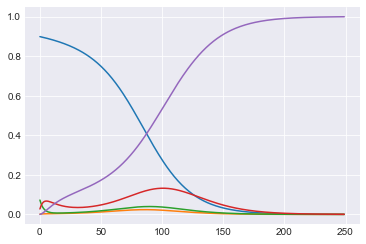

In [6]:
ref_traj = model.run(250)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(1.0, compartments)
tmat.add_norm_dist('E', 'I', 7, 2)
tmat.add_norm_dist('I', 'R', 11, 4)
T = tmat.sample(1)[0]
T

array([[0.80633993, 0.19366007, 0.        ],
       [0.        , 0.92180699, 0.07819301],
       [0.        , 0.        , 1.        ]])

In [8]:
def sample_rmat(N, loc=1.0):
    M = 4
    R = np.abs(np.random.normal(size=(N,M,M), loc=loc))
    R = R / np.sum(R, axis=2).reshape(N,M,1)
    return R
rs = sample_rmat(2)
np.sum(rs[0], axis=1)

array([1., 1., 1., 1.])

In [9]:
# starting fractions
def make_starts(N):
    start = np.zeros((N, M, C))
    # pick 2 starting patches
    seeds = [[0, 1]]
    for i in range(N):
        for j in np.random.randint(0, M, size=1):
            start[i,j,compartments.index('I')] = np.abs(ss.norm.rvs(loc=0.05, scale=0.15))
    return start
make_starts(1)

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.14126016, 0.        ],
        [0.        , 0.        , 0.        ]]])

In [10]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
for b in tqdm.tqdm(range(batches)):
    start = make_starts(N)
    Rmat = sample_rmat(N)
    infect = maxentep.contact_infection_func(tf.constant([np.random.uniform(0.01,0.25) for _ in range(N)]),
                                            infections_compartments)
    T = tmat.sample(N)
    model = maxentep.MetaModel(start, Rmat, T, infect)
    outs.append(model.run(250))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]

(8192, 250, 4, 4)


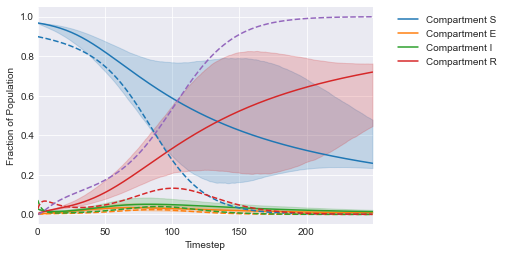

In [11]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [42]:
npoints = 10
prior = maxentep.Laplace(0.025)
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj, [0, -1], npoints, prior, noise=0.01)

115 0.68230236 0.6807259330972734
122 0.74383014 0.7380573040638018
10 0.04490301 0.054102493898420076
157 0.93219507 0.9379330268520898
185 0.98039263 0.9848117502855239
87 0.40572652 0.39933600052418117
241 0.9986073 1.0
227 0.9972763 1.0
59 0.21080892 0.21158979439228776
3 0.0111 0.014373434196851912


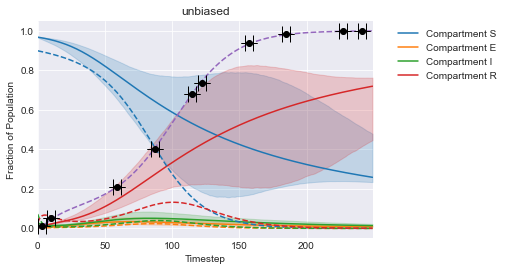

In [43]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [44]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [45]:
history = me_model.fit(trajs, batch_size=16,epochs=20)

Epoch 1/20
512/512 [==============================] - 0s 855us/step - loss: 0.0134
Epoch 2/20
512/512 [==============================] - 0s 862us/step - loss: 0.0043
Epoch 3/20
512/512 [==============================] - 0s 814us/step - loss: 0.0035
Epoch 4/20
512/512 [==============================] - 0s 827us/step - loss: 0.0031
Epoch 5/20
512/512 [==============================] - 0s 879us/step - loss: 0.0029
Epoch 6/20
512/512 [==============================] - 0s 853us/step - loss: 0.0029
Epoch 7/20
512/512 [==============================] - 0s 771us/step - loss: 0.0026
Epoch 8/20
512/512 [==============================] - 0s 766us/step - loss: 0.0025
Epoch 9/20
512/512 [==============================] - 0s 768us/step - loss: 0.0026
Epoch 10/20
512/512 [==============================] - 0s 853us/step - loss: 0.0025
Epoch 11/20
512/512 [==============================] - 1s 983us/step - loss: 0.0025
Epoch 12/20
512/512 [==============================] - 0s 811us/step - loss: 0.0025
E

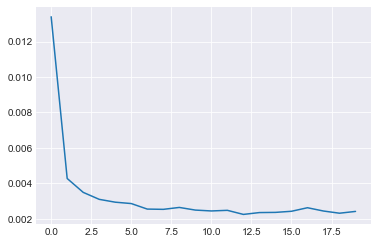

In [46]:
plt.plot(history.history['loss'])

In [47]:
me_model.lambdas

<tf.Variable 'maxent-lambda:0' shape=(10,) dtype=float32, numpy=
array([-1.5192697, -1.849355 , -3.123859 , -3.0118024, -2.905413 ,
        2.8379369, -1.550339 , -1.9152814,  4.0719895, -1.5951495],
      dtype=float32)>

## Now visualize results

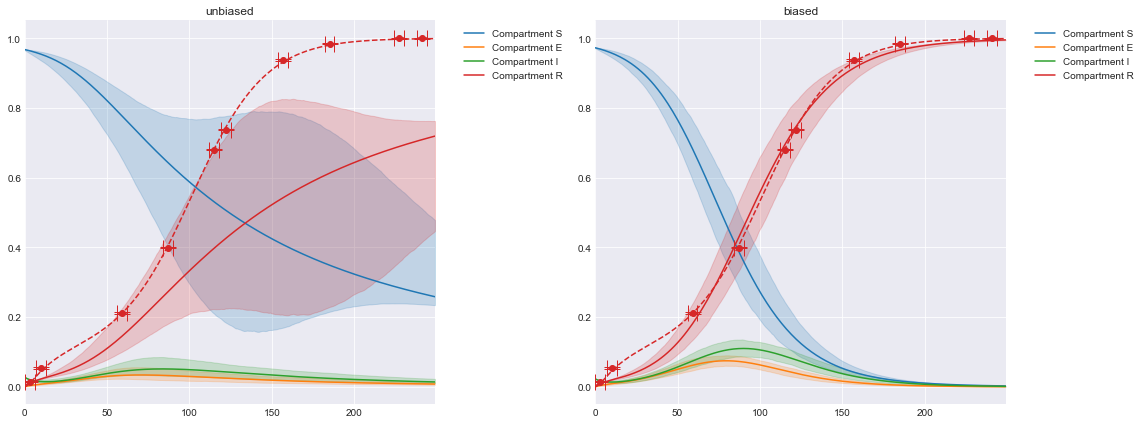

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs[0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0])
axs[0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[0], me_model.lambdas[i], color='C3')
axs[1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[1])
axs[1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
for i,pf in enumerate(plot_fxns):
    pf(axs[1], me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.show()